# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('../hwassets/data/hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

Let's visualize the training set.

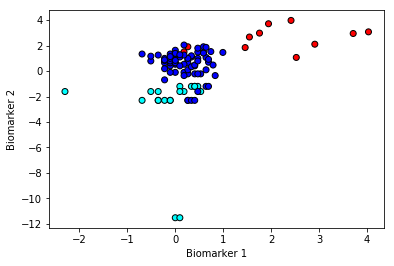

In [3]:
colors = ['blue', 'cyan', 'red']
plt.scatter(data_train.iloc[:, 0], data_train.iloc[:, 1],
            c=np.array(colors)[data_train.iloc[:, 2].astype('int').values - 1], 
            cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel(data_train.columns[0])
plt.ylabel(data_train.columns[1]);

It appears that a linear classifier will not be able to perfectly separate the points. But it does appear that a linear classifier should seem to do reasonably well here. 

The one-vs-rest (OvR) logistic regression classifier trains a single classifier per class with the samples of that class as the positive class and the remaining samples as the negative class. A data point is classified according to the class with the maximum score. For the multinomial model, one classifier is fit where the entire (multinomial) probability distribution of all of the classes is considered and the class that minimizes the cross-entropy loss is selected.

Let's fit linear classification models on the thyroid data set using both the methods and tune the regularization parameter using cross validation.

In [4]:
X_train, X_test = data_train.drop('Diagnosis', axis=1), data_test.drop('Diagnosis', axis=1)
y_train, y_test = data_train.Diagnosis, data_test.Diagnosis

In [5]:
def train_test_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    return train_accuracy, test_accuracy

In [6]:
ovr = LogisticRegressionCV(multi_class='ovr')
ovr_train_accuracy, ovr_test_accuracy = train_test_accuracy(
    ovr, X_train, y_train, X_test, y_test)
multi = LogisticRegressionCV(multi_class='multinomial')
multi_train_accuracy, multi_test_accuracy = train_test_accuracy(
    multi, X_train, y_train, X_test, y_test)

In [7]:
def print_accuracies(train_accuracy, test_accuracy, model_name):
    print('Model:', model_name)
    print('Train accuracy:', train_accuracy)
    print('Test accuracy:', test_accuracy)
    
print_accuracies(ovr_train_accuracy, ovr_test_accuracy, 'OvR')
print_accuracies(multi_train_accuracy, multi_test_accuracy, 'Multinomial')

Model: OvR
Train accuracy: 0.8431372549019608
Test accuracy: 0.8407079646017699
Model: Multinomial
Train accuracy: 0.8921568627450981
Test accuracy: 0.8849557522123894


We see that the classification accuracy on the training and test sets is higher for the multinomial model.

Also, let's compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

In [8]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
multi_poly = LogisticRegressionCV(multi_class='multinomial')
multi_poly_train_accuracy, multi_poly_test_accuracy = train_test_accuracy(
    multi_poly, X_train_poly, y_train, X_test_poly, y_test)
print_accuracies(multi_poly_train_accuracy, multi_poly_test_accuracy,
                 'Multinomial with polynomial (degree=2) terms')

lda = LinearDiscriminantAnalysis()
lda_train_accuracy, lda_test_accuracy = train_test_accuracy(
    lda, X_train, y_train, X_test, y_test)
print_accuracies(lda_train_accuracy, lda_test_accuracy,
                 'LDA')

qda = QuadraticDiscriminantAnalysis()
qda_train_accuracy, qda_test_accuracy = train_test_accuracy(
    qda, X_train, y_train, X_test, y_test)
print_accuracies(qda_train_accuracy, qda_test_accuracy,
                 'QDA')

n_folds = 5
val_accuracies = []
for n_neighbours in range(1, int(X_train.shape[0] -  X_train.shape[0] / n_folds), 2):
    knn = KNeighborsClassifier(n_neighbors=n_neighbours)
    val_accuracies.append(
        cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=n_folds).mean())
knn_max_accuracy = np.argmax(val_accuracies) * 2 + 1

knn = KNeighborsClassifier(n_neighbors=knn_max_accuracy)
knn_train_accuracy, knn_test_accuracy = train_test_accuracy(
    knn, X_train, y_train, X_test, y_test)
print_accuracies(knn_train_accuracy, knn_test_accuracy,
                 'KNN (k={0})'.format(knn_max_accuracy))

Model: Multinomial with polynomial (degree=2) terms
Train accuracy: 0.8921568627450981
Test accuracy: 0.8938053097345132
Model: LDA
Train accuracy: 0.8725490196078431
Test accuracy: 0.831858407079646
Model: QDA
Train accuracy: 0.8725490196078431
Test accuracy: 0.8495575221238938
Model: KNN (k=3)
Train accuracy: 0.9313725490196079
Test accuracy: 0.8672566371681416


We can see that the inclusion of the polynomial terms in logistic regression yields a better test accuracy compared to the model with only linear terms.

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [9]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

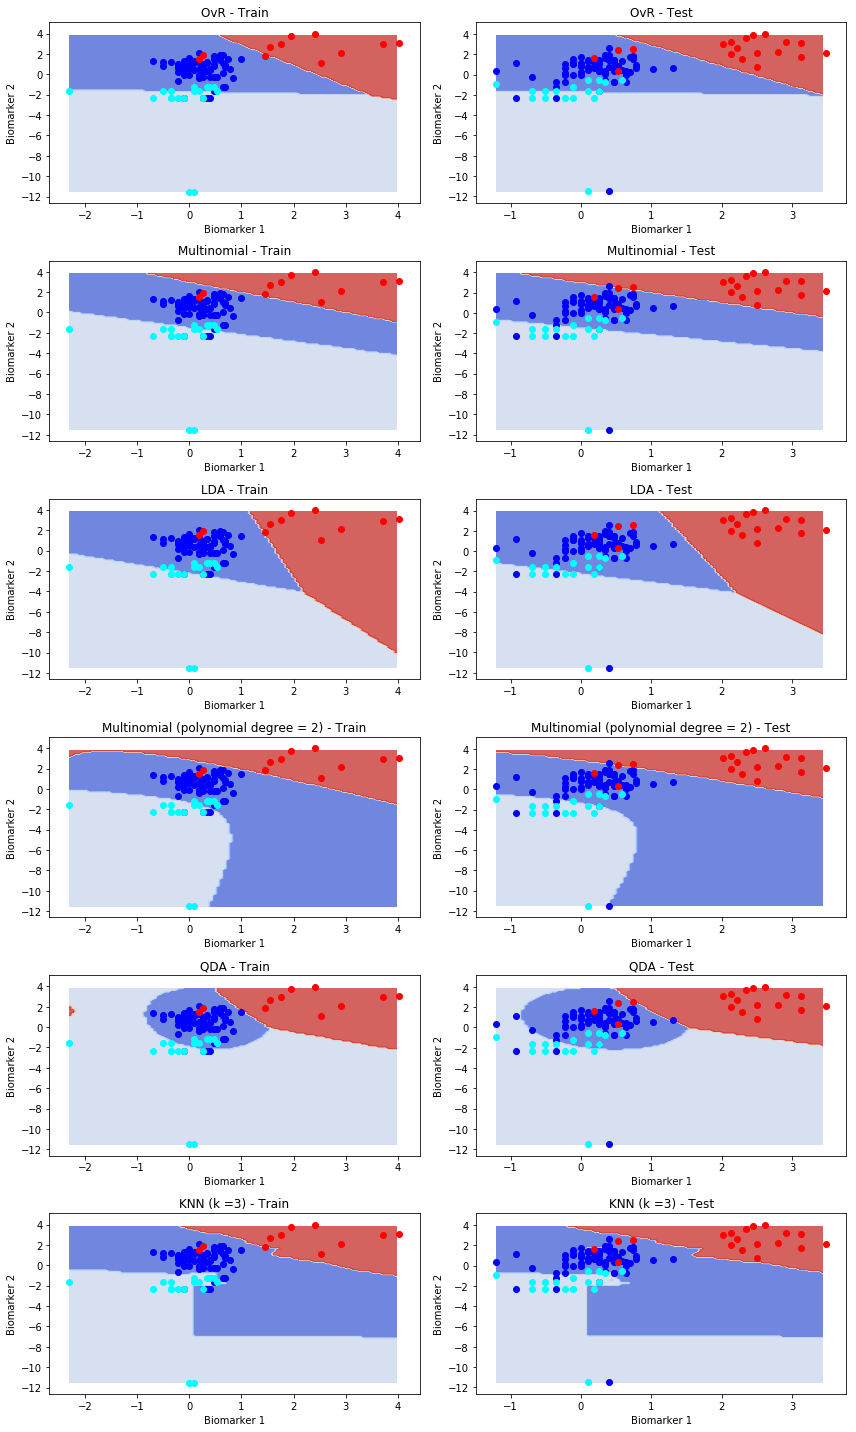

In [10]:
fig, axes = plt.subplots(6, 2, figsize = (12, 20))

plot_decision_boundary(X_train.values, y_train.values, ovr, 'OvR - Train',
                       axes[0, 0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, ovr, 'OvR - Test',
                       axes[0, 1], poly_degree=None)

plot_decision_boundary(X_train.values, y_train.values, multi, 'Multinomial - Train',
                       axes[1, 0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, multi, 'Multinomial - Test',
                       axes[1, 1], poly_degree=None)

plot_decision_boundary(X_train.values, y_train.values, lda, 'LDA - Train',
                       axes[2, 0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, lda, 'LDA - Test',
                       axes[2, 1], poly_degree=None)

plot_decision_boundary(X_train.values, y_train.values, multi_poly,
                       'Multinomial (polynomial degree = 2) - Train',
                       axes[3, 0], poly_degree=2)
plot_decision_boundary(X_test.values, y_test.values, multi_poly,
                       'Multinomial (polynomial degree = 2) - Test',
                       axes[3, 1], poly_degree=2)

plot_decision_boundary(X_train.values, y_train.values, qda, 'QDA - Train',
                       axes[4, 0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, qda, 'QDA - Test',
                       axes[4, 1], poly_degree=None)

plot_decision_boundary(X_train.values, y_train.values, knn,
                       'KNN (k =' + str(knn_max_accuracy) + ') - Train',
                       axes[5, 0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, knn,
                       'KNN (k =' + str(knn_max_accuracy) + ') - Test',
                       axes[5, 1], poly_degree=None)

fig.tight_layout()

We can see that the decision boundaries for the multinomial logistic regression models is better at separating the classes than the OvR. Also, it is clear that the linear logistic regression models are better at separating the classes than LDA. Most of the difference is due to their ability to separate the blue and cyan classes. The plots illustrate that the decision boundaries for the quadratic logistic regression model are better at separating the classes than those for QDA. Again, most of the difference is due to the model's ability to separate the blue and cyan classes. Likely, the assumptions being made by the QDA model (multivariate Normal distributions in each class) are not valid for this data.

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

Let's look at the training and test accuracies as a function of the tree depth.

In [11]:
train_accuracies = []
test_accuracies = []
max_depths = list(range(2, 11))
for max_depth in max_depths:
    tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    test_accuracies.append(tree.score(X_test, y_test))

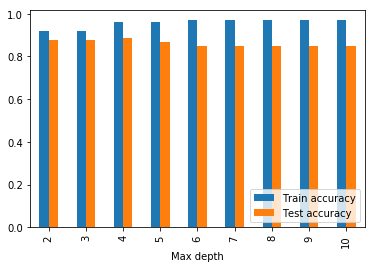

In [12]:
accuracies = pd.DataFrame(np.column_stack((max_depths, train_accuracies, test_accuracies)),
             columns=['Max depth', 'Train accuracy', 'Test accuracy'])
accuracies['Max depth'] = accuracies['Max depth'].astype('int')
accuracies = accuracies.set_index('Max depth')
ax = accuracies.plot.bar()
ax.legend(loc='lower right');

We can see at a max depth of 6 that the fitted decision tree model achieves near-perfect classification on the training set. However, we see that the test accuracy has also decreased which shows that the decision tree is overfitting.

Let's now use 5-fold cross-validation to choose the optimal tree depth and then examine the classification accuracy on the training and test sets.

In [13]:
n_folds = 5
val_accuracies = []
for max_depth in max_depths:
    tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    val_accuracies.append(
        cross_val_score(tree, X_train, y_train, scoring='accuracy', cv=n_folds).mean())
tree_max_accuracy = np.argmax(val_accuracies) + 2

tree = DecisionTreeClassifier(criterion='gini', max_depth=tree_max_accuracy)
tree_train_accuracy, tree_test_accuracy = train_test_accuracy(
    tree, X_train, y_train, X_test, y_test)
print_accuracies(tree_train_accuracy, tree_test_accuracy,
                 'Decision tree (max depth={0})'.format(tree_max_accuracy))

Model: Decision tree (max depth=2)
Train accuracy: 0.9215686274509803
Test accuracy: 0.8761061946902655


We can see that the performance of the Decision Tree model is better than all of the previous models except for the multinomial models. 

Let's take a look at the decision boundary of the Decision Tree.

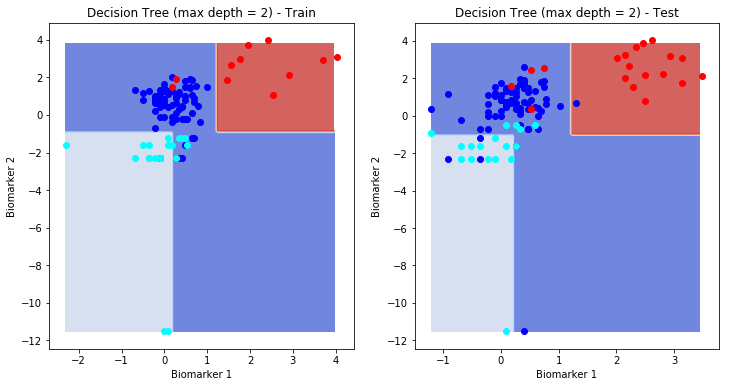

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

plot_decision_boundary(X_train.values, y_train.values, tree,
                       'Decision Tree (max depth = 2) - Train',
                       axes[0], poly_degree=None)
plot_decision_boundary(X_test.values, y_test.values, tree,
                       'Decision Tree (max depth = 2) - Test',
                       axes[1], poly_degree=None)

We see that the decision boundary of the Decision Tree is very different from the other models. It consists of a set of straight lines parallel to the parameter axes. These straight lines correspond to a threshold for the binary decision of a particular parameter.

Let's now generate a visualization of the tree diagram for the fitted model which we can visualize at http://www.webgraphviz.com/.

In [15]:
export_graphviz(tree, out_file="tree.dot")

Based on the visualization, the fitted model diagnoses 'hypothyroidism' for a patient by first checking if the value of `Biomarker 2` is less than -0.949. If it is not then it checks if the value of `Biomarker 1` is less than 1.226. If it is not then the model diagnoses 'hypothyroidism' for a patient.

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

We now compare and contrast the pros and cons of the six models: 

| Model                             | Classification | Decision boundary complexity | Memory | Interpretability | 
| --------------------------------- | -------------- | ---------------------------- | ------ | ---------------- |
| linear logistic regression        |     0.88       |            Low               | Low    |   Medium         |   
| logistic regression + poly terms  |     0.89       |            Medium            | Medium |   Low            |
| LDA                               |     0.83       |            Low               | Low    |   Medium         |
| QDA                               |     0.85       |            Medium            | Medium |   Medium         |
| k-NN                              |     0.87       |            High              | High   |   High           | 
| decision tree                     |     0.88       |            Low               | Low    |   High           |

If I was a clinician using the classifier to diagnose thyroid disorders in patients I would be most comfortable using the decision tree model due to it's ease of interpretability and relatively high classification accuracy.

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [16]:
def hospital_cost(y_true, y_pred, misclassify_cost=5000, abstain_cost=1000):
    abstain_costs = np.sum(y_pred == -1) * abstain_cost
    error_costs = misclassify_cost * sum(y_true[y_pred != -1] != y_pred[y_pred != -1]) 
    total_costs = (abstain_costs + error_costs) / y_true.shape[0]
    return total_costs

In [17]:
print('Average cost per patient for OvR logistic regression model: $',
      round(hospital_cost(y_test, ovr.predict(X_test)), 2))

Average cost per patient for OvR logistic regression model: $ 796.46


Let's take a look at the largest predicted probabibility and it's min and max for each observation in the test set. 

In [18]:
largest_probs = np.max(ovr.predict_proba(X_test), axis=1)
print(largest_probs)
print('Min largest probability:', np.min(largest_probs))
print('Max largest probability:', np.max(largest_probs))

[0.95230244 0.95840203 0.96871181 0.96466856 0.96334035 0.95845008
 0.9589431  0.92316404 0.88682794 0.95617354 0.95202972 0.95272482
 0.67695065 0.64329666 0.50531969 0.90162908 0.85292037 0.62249774
 0.94371494 0.92417185 0.95319038 0.99166826 0.67466711 0.82524432
 0.94004434 0.76990559 0.85982747 0.8159925  0.95665732 0.6203089
 0.8542587  0.95561107 0.94782328 0.85283048 0.9095256  0.93889599
 0.9429661  0.71676154 0.83145995 0.59289017 0.90162908 0.83145995
 0.60189118 0.58674397 0.50892066 0.73287266 0.96582222 0.61973095
 0.56821605 0.70765746 0.83586455 0.55736368 0.96607489 0.81804506
 0.95427741 0.80444238 0.91543049 0.73454246 0.90021993 0.5315695
 0.88853896 0.58167525 0.65743998 0.96735225 0.95874694 0.81472069
 0.58838299 0.79181328 0.96735225 0.96457335 0.59446424 0.96677124
 0.91824267 0.91981562 0.50198804 0.94105009 0.87747798 0.59675833
 0.59468158 0.58156314 0.91693127 0.93911597 0.94907571 0.62970129
 0.60249969 0.96029651 0.94860454 0.91495977 0.750742   0.678814

When the largest probability is below a certain threshold it means the classifier is not so sure about the prediction. Therefore, we should choose to abstain from making a prediction. Our aim is to find the threshold that minimizes the cost for the hospital. We do this by trying different thresholds between the min and max largest probability and choosing the one that minimizes the cost.

In [19]:
costs = []
y_hat = ovr.predict(X_test)
thresholds = np.linspace(0.5, 1.0, 51)
for threshold in thresholds:
    for obs, max_prob in enumerate(largest_probs):
        if max_prob < threshold:
            y_hat[obs] = -1 # abstain
    costs.append(hospital_cost(y_test, y_hat))
print('Min average cost per patient for OvR logistic regression model is ${0} '
      'occuring at an abstain threshold of {1}'.format(np.round(np.min(costs), 2),
                                                        thresholds[np.argmin(costs)]))

Min average cost per patient for OvR logistic regression model is $513.27 occuring at an abstain threshold of 0.59
